# PINN Solution of the Cahn Hilliard PDE

This PyTorch code demonstrates the application of physically-informed neural networks (PINN) in the solution of a well-known Cahn Hillard PDE with periodic boundary condition
\begin{aligned}
  &u_t = \epsilon_1(-u_{xx}  - \epsilon_2u_{xxxx} + (u^3)_{xx}), \quad (t, x) \in [0, T]\times[-L, L]\\
  &u(0, x) = u_0(x), \quad \forall x \in [-L, L] \\
  &u(t, -L) = u(t, L), \quad \forall t \in [0, T]
\end{aligned}
where $\epsilon_1, \epsilon-2 > 0$ are given constants, and $[-L, L]$ covers one full period, i.e. $T = 2L$.

Due to the long time to compute forth derivative through back propagation, we will let $v = u_{xx}$, and 
$$
(u^3)_{xx} = (3u^2u_x)_x = 6uu_x^2 + 3u^2u_{xx},
$$
then
$$
u_t = \epsilon_1(-u_{xx}  - \epsilon_2u_{xxxx} + (u^3)_{xx}) = \epsilon_1(-u - \epsilon_2u_{xx} + u^3)_{xx}
$$
becomes
\begin{aligned}
u_t &= \epsilon_1v_{xx}, \\
v &= -(u - u^3) - \epsilon_2u_{xx}
\end{aligned}

## Libraries and Dependencies

In [1]:
import torch
import torch.optim
import torch.optim.lr_scheduler as lr_scheduler
from itertools import chain
from collections import OrderedDict
from pyDOE import lhs
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
# set the random seed
np.random.seed(1234)

In [2]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#
print(f"Working on {device}")

Working on mps


In [3]:
epsilon1 = 1e-2
epsilon2 = 1e-4
L = 1.0
xlo = -L
xhi = L
period = xhi - xlo
tlo = 0.0
thi = 1.0
pi_ten = torch.tensor(np.pi).float().to(device)
u0 = lambda x: -np.cos(2.0 * np.pi * x)
u0_ten = lambda x: -torch.cos(2.0 * pi_ten * x)
v0 = lambda x: 4*np.pi**2*np.cos(2*np.pi*x)
v0_ten = lambda x: 4*pi_ten**2*torch.cos(2*pi_ten * x)

## Physics-informed Neural Networks

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        # parameters
        self.depth = len(layers) - 1
        # set up layer order dict
        self.activation = torch.nn.Tanh
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        self.layers[0].weight = torch.load('initial_weight.pt')
    def forward(self, x):
        out = self.layers(x)
        return out

In [5]:
class PhysicsInformedNN():
    def __init__(self, period, epsilon1,epsilon2, X_IC, u_IC, v_IC, X_BC, u_BC, v_BC, X_PDE, layers):
        # IC data point
        self.t_IC = torch.tensor(X_IC[:, 0:1]).float().to(device)
        self.x_IC = torch.tensor(X_IC[:, 1:2]).float().to(device)
        self.u_IC = torch.tensor(u_IC).float().to(device)
        self.v_IC = torch.tensor(v_IC).float().to(device) 
        N_IC = X_IC.shape[0]
        self.LW_uIC = torch.nn.ParameterList([torch.nn.Parameter(torch.ones(N_IC, 1).float(), requires_grad=True).to(device)])
        self.LW_vIC = torch.nn.ParameterList([torch.nn.Parameter(torch.ones(N_IC, 1).float(), requires_grad=True).to(device)])
        # BC data point
        self.t_BC = torch.tensor(X_BC[:, 0:1]).float().to(device)
        self.x_BC = torch.tensor(X_BC[:, 1:2]).float().to(device)
        self.u_BC = torch.tensor(u_BC).float().to(device)
        self.v_BC = torch.tensor(v_BC).float().to(device) 
        self.period = torch.tensor(period).float().to(device)
        N_BC = X_BC.shape[0]
        self.LW_uBC = torch.nn.ParameterList([torch.nn.Parameter(torch.ones(N_BC, 1).float(), requires_grad=True).to(device)])        
        self.LW_vBC = torch.nn.ParameterList([torch.nn.Parameter(torch.ones(N_BC, 1).float(), requires_grad=True).to(device)])        
        # PDE data, gradients will be computed on these points so requires_grad = True
        self.t_PDE = torch.tensor(X_PDE[:, 0:1], requires_grad=True).float().to(device)
        self.x_PDE = torch.tensor(X_PDE[:, 1:2], requires_grad=True).float().to(device)
       
        N_PDE = X_PDE.shape[0]
        self.LW_uPDE = torch.nn.ParameterList([torch.nn.Parameter(torch.ones(N_PDE, 1).float(), requires_grad=True).to(device)])
        self.LW_vPDE = torch.nn.ParameterList([torch.nn.Parameter(torch.ones(N_PDE, 1).float(), requires_grad=True).to(device)])

        # equation related parameters
        self.epsilon1 = torch.tensor(epsilon1).float().to(device)
        self.epsilon2 = torch.tensor(epsilon2).float().to(device)
       
        # layers to build Neural Net
        self.layers = layers
        # deep neural networks
        self.dnn = DNN(layers).to(device)    
        # prepare the optimizer
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters(), lr = 1e-3)
        self.optimizer_LW_uIC = torch.optim.Adam(self.LW_uIC.parameters(), lr = 5e-3)
        self.optimizer_LW_uBC = torch.optim.Adam(self.LW_uBC.parameters(), lr = 5e-3)
        self.optimizer_LW_uPDE = torch.optim.Adam(self.LW_uPDE.parameters(), lr = 5e-3)
        self.optimizer_LW_vIC = torch.optim.Adam(self.LW_vIC.parameters(), lr = 5e-3)
        self.optimizer_LW_vBC = torch.optim.Adam(self.LW_vBC.parameters(), lr = 5e-3)
        self.optimizer_LW_vPDE = torch.optim.Adam(self.LW_vPDE.parameters(), lr = 5e-3)
        # add a learning rate scheduler
        
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-8, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )        
        
        self.iter = 0
    # evaluater neural network, no transformation
    def NN_eval(self, t, x):  
        NN = self.dnn(torch.cat([t, x], dim = 1)) 
        u = NN[:, 0][:, None]
        v = NN[:, 1][:, None]
        return u,v
    # compute the PDE
    def pde_eval(self, t, x):
        """ The pytorch autograd version of calculating residual """
        u, v = self.NN_eval(t, x)
        # compute the derivatives for u
        u_t  = torch.autograd.grad(u,   t, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_x  = torch.autograd.grad(u,   x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs = torch.ones_like(u), retain_graph = True, create_graph=True)[0]
        v_x  = torch.autograd.grad(v,   x, grad_outputs = torch.ones_like(v), retain_graph = True, create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs = torch.ones_like(v), retain_graph = True, create_graph=True)[0]
        Eq1  = u_t -self.epsilon1 * v_xx
        Eq2  = v +  (u + self.epsilon2 * u_xx - torch.pow(u, 3.0))
        return Eq1, Eq2
    # compute the total loss for the second-order optimizer
    def loss_func(self):
        # reset the gradient
        self.optimizer_LBFGS.zero_grad()
        # compute IC loss
        uIC_pred, vIC_pred = self.NN_eval(self.t_IC, self.x_IC)
    
        loss_IC = torch.mean((self.LW_uIC[0] *(self.u_IC - uIC_pred))**2.0) + torch.mean((self.LW_vIC[0] *(self.v_IC - vIC_pred))**2.0)
        # compute PBC loss
        uBC_pred_left, vBC_pred_left = self.NN_eval(self.t_BC, self.x_BC)
        uBC_pred_right, vBC_pred_right = self.NN_eval(self.t_BC, self.x_BC+self.period)
        loss_BC = torch.mean((self.LW_uBC[0]*(uBC_pred_left - uBC_pred_right))**2.0) + torch.mean((self.LW_vBC[0]*(vBC_pred_left - vBC_pred_right))**2.0)
        
        
        pde1_pred, pde2_pred = self.pde_eval(self.t_PDE, self.x_PDE)
        loss_PDE = torch.mean((self.LW_uPDE[0]*pde1_pred )** 2) + torch.mean((self.LW_vPDE[0]*pde2_pred )** 2)   
        
       
        # compute the total loss, it can be weighted
        loss = loss_IC + loss_BC + loss_PDE
        # backward propagation
        loss.backward()
        # increase the iteration counter
        self.iter += 1
        # output
        # output the progress
        if self.iter % 1000 == 0:
            end_time = time.time()
            print('Iter %5d, Total: %10.4e' % (self.iter, loss.item()))
            print('IC: %10.4e, PBC: %10.4e, PDE: %10.4e' % (loss_IC.item(), loss_BC.item(), loss_PDE.item()))
            self.start_time = end_time
        return loss
    #
    def train(self, nIter):
        # start the timer
        start_time = time.time()        
        # start the training with Adam first
        self.dnn.train()
        print('Starting with Adam')
        for epoch in range(nIter):
            # compute IC loss
            uIC_pred, vIC_pred = self.NN_eval(self.t_IC, self.x_IC)
    
            loss_IC = torch.mean((self.LW_uIC[0] *(self.u_IC - uIC_pred))**2.0) + torch.mean((self.LW_vIC[0] *(self.v_IC - vIC_pred))**2.0)
        # compute PBC loss
            uBC_pred_left, vBC_pred_left = self.NN_eval(self.t_BC, self.x_BC)
            uBC_pred_right, vBC_pred_right = self.NN_eval(self.t_BC, self.x_BC+self.period)
            loss_BC = torch.mean((self.LW_uBC[0]*(uBC_pred_left - uBC_pred_right))**2.0) + torch.mean((self.LW_vBC[0]*(vBC_pred_left - vBC_pred_right))**2.0)
        
        
            pde1_pred, pde2_pred = self.pde_eval(self.t_PDE, self.x_PDE)
            loss_PDE = torch.mean((self.LW_uPDE[0]*pde1_pred )** 2) + torch.mean((self.LW_vPDE[0]*pde2_pred )** 2)   
        
       
        # compute the total loss, it can be weighted
            loss = loss_IC + loss_BC + loss_PDE
            # Backward and optimize
            self.optimizer_Adam.zero_grad()
            self.optimizer_LW_uIC.zero_grad()
            self.optimizer_LW_uBC.zero_grad()
            self.optimizer_LW_uPDE.zero_grad()
            self.optimizer_LW_vIC.zero_grad()
            self.optimizer_LW_vBC.zero_grad()
            self.optimizer_LW_vPDE.zero_grad()
            loss.backward()
            self.optimizer_Adam.step() 
            self.LW_uIC[0].grad.data = -self.LW_uIC[0].grad.data
            self.LW_uBC[0].grad.data = -self.LW_uBC[0].grad.data
            self.LW_uPDE[0].grad.data = -self.LW_uPDE[0].grad.data
            self.LW_vIC[0].grad.data = -self.LW_vIC[0].grad.data
            self.LW_vBC[0].grad.data = -self.LW_vBC[0].grad.data
            self.LW_vPDE[0].grad.data = -self.LW_vPDE[0].grad.data
            self.optimizer_LW_uIC.step()
            self.optimizer_LW_uBC.step()
            self.optimizer_LW_uPDE.step()
            self.optimizer_LW_vIC.step()
            self.optimizer_LW_vBC.step()
            self.optimizer_LW_vPDE.step()
            # output the progress
            if (epoch + 1) % 1000 == 0:
                end_time = time.time()
                print('Iter %5d, Total: %10.4e' % (epoch + 1, loss.item()))
                print('IC: %10.4e, PBC: %10.4e, PDE: %10.4e' % (loss_IC.item(), loss_BC.item(), loss_PDE.item()))
                print('For uIC,  min uLW: %10.4e, max uLW: %10.4e' %(torch.min(self.LW_uIC[0]).item(), torch.max(self.LW_uIC[0]).item()))
                print('For uBC,  min uLW: %10.4e, max uLW: %10.4e' %(torch.min(self.LW_uBC[0]).item(), torch.max(self.LW_uBC[0]).item()))
                print('For uPDE, min uLW: %10.4e, max uLW: %10.4e' %(torch.min(self.LW_uPDE[0]).item(), torch.max(self.LW_uPDE[0]).item()))
                print('For vIC,  min vLW: %10.4e, max vLW: %10.4e' %(torch.min(self.LW_vIC[0]).item(), torch.max(self.LW_vIC[0]).item()))
                print('For vBC,  min vLW: %10.4e, max vLW: %10.4e' %(torch.min(self.LW_vBC[0]).item(), torch.max(self.LW_vBC[0]).item()))
                print('For vPDE, min vLW: %10.4e, max vLW: %10.4e' %(torch.min(self.LW_vPDE[0]).item(), torch.max(self.LW_vPDE[0]).item()))
                
                start_time = end_time
                # change the learning rate
                
        # Using the second-order L-BFGS optimizer
        print('Starting with L-BFGS')
        
        self.optimizer_LBFGS.step(self.loss_func)                
    #        
    def predict(self, X):
        t = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        x = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)
        self.dnn.eval()
        u, v = self.NN_eval(t, x)
        u = u.detach().cpu().numpy()
        v = v.detach().cpu().numpy()
        return u,v


## Configurations

## Training

In [6]:
layers = [2, 32, 32, 32, 32, 32, 32, 32, 2]
N_IC = 128
ptsIC=np.load('ptsIC.npy')
ptsBC=np.load('ptsBC.npy')
ptsPDE=np.load('random_data.npy')
uBC = np.load('uBC.npy')
vBC = np.load('vBC.npy')
x_IC = np.expand_dims(np.linspace(xlo, xhi, N_IC), axis = 1)
uIC = u0(x_IC)
vIC = v0(x_IC)
model = PhysicsInformedNN(period, epsilon1, epsilon2, ptsIC, uIC, vIC, ptsBC, uBC, vBC, ptsPDE, layers)
model.train(50000)

Starting with Adam
Iter  1000, Total: 5.5650e+04
IC: 5.5371e+04, PBC: 6.2255e-01, PDE: 2.7816e+02
For uIC,  min uLW: 5.4930e+00, max uLW: 1.1465e+01
For uBC,  min uLW: 1.4958e+00, max uLW: 4.6403e+00
For uPDE, min uLW: 1.3800e+00, max uLW: 7.0557e+00
For vIC,  min vLW: 4.3589e+00, max vLW: 1.1263e+01
For vBC,  min vLW: 1.6704e+00, max vLW: 5.9002e+00
For vPDE, min vLW: 4.5783e+00, max vLW: 1.2989e+01
Iter  2000, Total: 2.0713e+05
IC: 2.0578e+05, PBC: 5.6342e-02, PDE: 1.3459e+03
For uIC,  min uLW: 6.5143e+00, max uLW: 2.1742e+01
For uBC,  min uLW: 1.4958e+00, max uLW: 4.6403e+00
For uPDE, min uLW: 1.3800e+00, max uLW: 1.3150e+01
For vIC,  min vLW: 6.1474e+00, max vLW: 2.1235e+01
For vBC,  min vLW: 1.6704e+00, max vLW: 6.1864e+00
For vPDE, min vLW: 7.8282e+00, max vLW: 2.2951e+01
Iter  3000, Total: 2.9765e+05
IC: 2.9567e+05, PBC: 1.5849e+02, PDE: 1.8164e+03
For uIC,  min uLW: 9.3907e+00, max uLW: 3.0321e+01
For uBC,  min uLW: 1.4958e+00, max uLW: 5.2503e+00
For uPDE, min uLW: 1.3800e+00,

Iter 23000, Total: 6.1758e+04
IC: 1.4453e+04, PBC: 7.0342e+03, PDE: 4.0271e+04
For uIC,  min uLW: 3.6211e+01, max uLW: 5.6611e+01
For uBC,  min uLW: 9.8126e+00, max uLW: 3.7577e+01
For uPDE, min uLW: 1.5434e+00, max uLW: 4.3553e+01
For vIC,  min vLW: 1.2564e+01, max vLW: 4.1774e+01
For vBC,  min vLW: 1.2225e+01, max vLW: 2.9149e+01
For vPDE, min vLW: 2.1853e+01, max vLW: 8.4729e+01
Iter 24000, Total: 4.3358e+04
IC: 7.7771e+03, PBC: 3.5506e+03, PDE: 3.2030e+04
For uIC,  min uLW: 3.7014e+01, max uLW: 5.7875e+01
For uBC,  min uLW: 9.9993e+00, max uLW: 3.8935e+01
For uPDE, min uLW: 1.5485e+00, max uLW: 5.0261e+01
For vIC,  min vLW: 1.2565e+01, max vLW: 4.1780e+01
For vBC,  min vLW: 1.2467e+01, max vLW: 3.2720e+01
For vPDE, min vLW: 2.1869e+01, max vLW: 8.6572e+01
Iter 25000, Total: 2.7552e+04
IC: 4.3808e+03, PBC: 1.8737e+03, PDE: 2.1297e+04
For uIC,  min uLW: 3.7024e+01, max uLW: 5.9117e+01
For uBC,  min uLW: 1.0019e+01, max uLW: 3.9391e+01
For uPDE, min uLW: 1.5494e+00, max uLW: 5.0862e+0

Iter 45000, Total: 1.5093e+04
IC: 5.2028e+03, PBC: 5.8096e+01, PDE: 9.8321e+03
For uIC,  min uLW: 4.5731e+01, max uLW: 1.0844e+02
For uBC,  min uLW: 2.1030e+01, max uLW: 6.6338e+01
For uPDE, min uLW: 2.3271e+00, max uLW: 8.3180e+01
For vIC,  min vLW: 1.3561e+01, max vLW: 4.5026e+01
For vBC,  min vLW: 1.8610e+01, max vLW: 6.4107e+01
For vPDE, min vLW: 2.4658e+01, max vLW: 1.5364e+02
Iter 46000, Total: 1.1230e+04
IC: 4.8555e+03, PBC: 3.1200e+01, PDE: 6.3437e+03
For uIC,  min uLW: 4.5820e+01, max uLW: 1.1243e+02
For uBC,  min uLW: 2.3721e+01, max uLW: 7.5463e+01
For uPDE, min uLW: 2.3463e+00, max uLW: 9.0937e+01
For vIC,  min vLW: 1.3561e+01, max vLW: 4.5029e+01
For vBC,  min vLW: 1.9226e+01, max vLW: 6.5152e+01
For vPDE, min vLW: 2.4663e+01, max vLW: 1.5779e+02
Iter 47000, Total: 2.4086e+05
IC: 9.1880e+04, PBC: 5.7321e+03, PDE: 1.4325e+05
For uIC,  min uLW: 4.6790e+01, max uLW: 1.1603e+02
For uBC,  min uLW: 2.5338e+01, max uLW: 7.8030e+01
For uPDE, min uLW: 2.5048e+00, max uLW: 9.3333e+0

In [7]:
t = np.linspace(tlo, thi, 101)
x = np.linspace(xlo, xhi, 201)
T, X = np.meshgrid(t, x)
pts_flat = np.hstack((T.flatten()[:, None], X.flatten()[:, None]))
u_pred, v_pred = model.predict(pts_flat)
            
u_pred = griddata(pts_flat, u_pred.flatten(), (T, X), method='cubic')

## Visualizations

In [8]:
data = scipy.io.loadmat('/Users/abraham/Desktop/PINN/New_Data/CH_1D.mat')
t = data['t'].flatten()[:,None]
x2 = data['x'].flatten()[:,None]
u_sol = np.real(data['Exact']).T

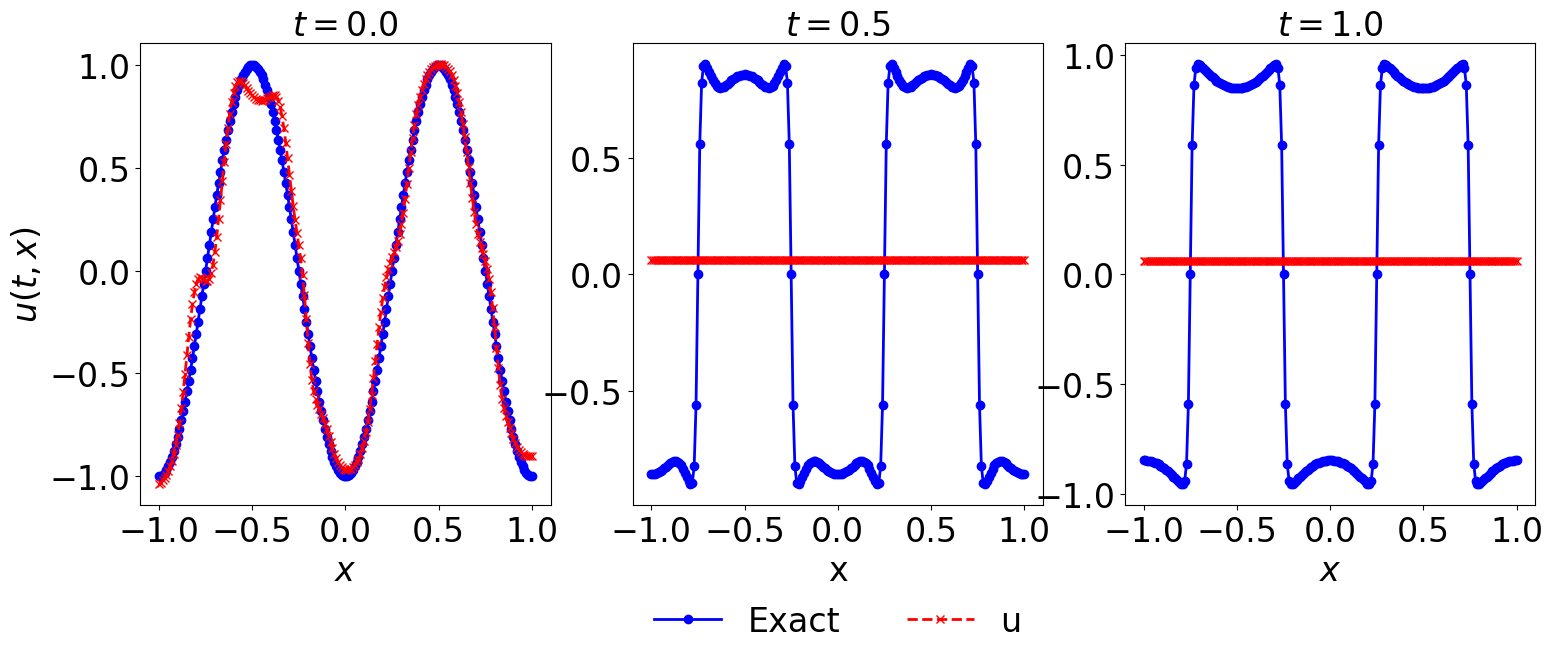

In [9]:
fig = plt.figure(figsize=(18, 6))
#
ax = plt.subplot(1, 3, 1)
ax.plot(x2, u_sol[0,:], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 0], 'rx--', linewidth = 2, label = 'u')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = %.1f$' %(t[0]), fontsize = 24)


plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

ax = plt.subplot(1, 3, 2)
ax.plot(x,u_sol[50,:], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 50], 'rx--', linewidth = 2, label = 'u')

ax.set_xlabel('x')




ax.set_title('$t = %.1f$' %(t[50]), fontsize = 24)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 24}
)
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

ax = plt.subplot(1, 3, 3)
ax.plot(x,u_sol[100,:], 'bo-', linewidth = 2, label = 'Exact')       
ax.plot(x, u_pred[:, 100], 'rx--', linewidth = 2, label = 'u')

ax.set_xlabel('$x$')




ax.set_title('$t = %.1f$' %(t[100]), fontsize = 24)
plt.locator_params(axis = 'y', nbins = 5)
plt.locator_params(axis = 'x', nbins = 5)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(24)

plt.show()
fig.savefig('CH_1D_BL+SA.png',format='png')

In [10]:
def relative_error_l2(pred,exact):
    error_l2 = np.sqrt(np.sum(np.power(pred - exact,2)))
    relative = error_l2/np.sqrt(np.sum(np.power(exact,2)))
    return relative
def relative_error_l1(pred,exact):
    error_l1 = np.sum(np.abs(pred-exact))
    relative = error_l1/np.sum(np.abs(exact))
    return relative
def relative_error_linf(pred,exact):
    error_linf = np.max(np.abs(pred-exact))
    relative = error_linf/np.max(np.abs(exact))
    return relative

In [11]:
print(f'l2: {relative_error_l2(u_pred.T,u_sol)}')
print(f'l1: {relative_error_l1(u_pred.T,u_sol)}')
print(f'linf: {relative_error_linf(u_pred.T,u_sol)}')

l2: 0.9992788466051551
l1: 0.9946538727523603
linf: 1.0656037662149418


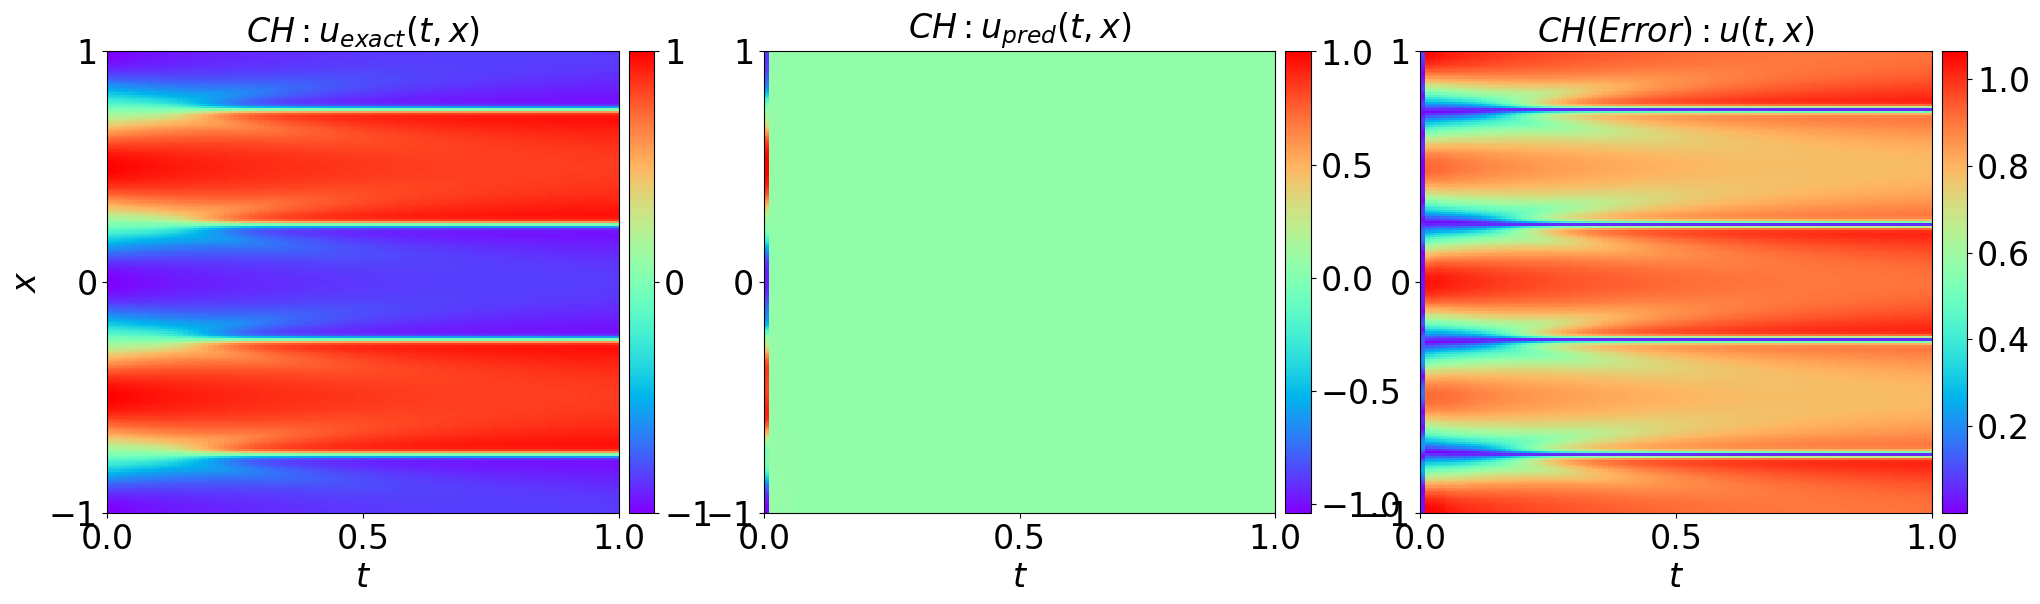

In [12]:
fig = plt.figure(figsize=(24, 6))

ax = plt.subplot(1, 3, 1)
h = ax.imshow(u_sol.T, interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=24) 

cbar.set_ticks([-1,0,1])



ax.set_xlabel('$t$', size=24)
ax.set_ylabel('$x$', size=24)
ax.set_xticks([0 ,0.5 ,1])
ax.set_yticks([-1 ,0 ,1])
ax.set_title('$CH: u_{exact}(t,x)$', fontsize = 24) # font size doubled
ax.tick_params(labelsize=24)

ax = plt.subplot(1, 3, 2)
h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=24) 




ax.set_xlabel('$t$', size=24)

ax.set_xticks([0 ,0.5 ,1])
ax.set_yticks([-1 ,0 ,1])
ax.set_title('$CH: u_{pred}(t,x)$', fontsize = 24) # font size doubled
ax.tick_params(labelsize=24)

ax = plt.subplot(1, 3, 3)
h = ax.imshow(np.abs(u_pred-u_sol.T), interpolation='nearest', cmap='rainbow', 
              extent=[tlo, thi, x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=24) 

ax.set_xlabel('$t$', size=24)

ax.set_xticks([0 ,0.5 ,1])
ax.set_yticks([-1 ,0 ,1])
ax.set_title('$CH(Error): u(t,x)$', fontsize = 24) # font size doubled
ax.tick_params(labelsize=24)


plt.show()
fig.savefig('CH3_1D_BL+SA.png',format='png')